In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
import json
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

import utils
from made import log_likelihood, log_posterior

plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_392977/2353345860.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
df = pd.read_csv(f"outputs/made/made-history.csv")

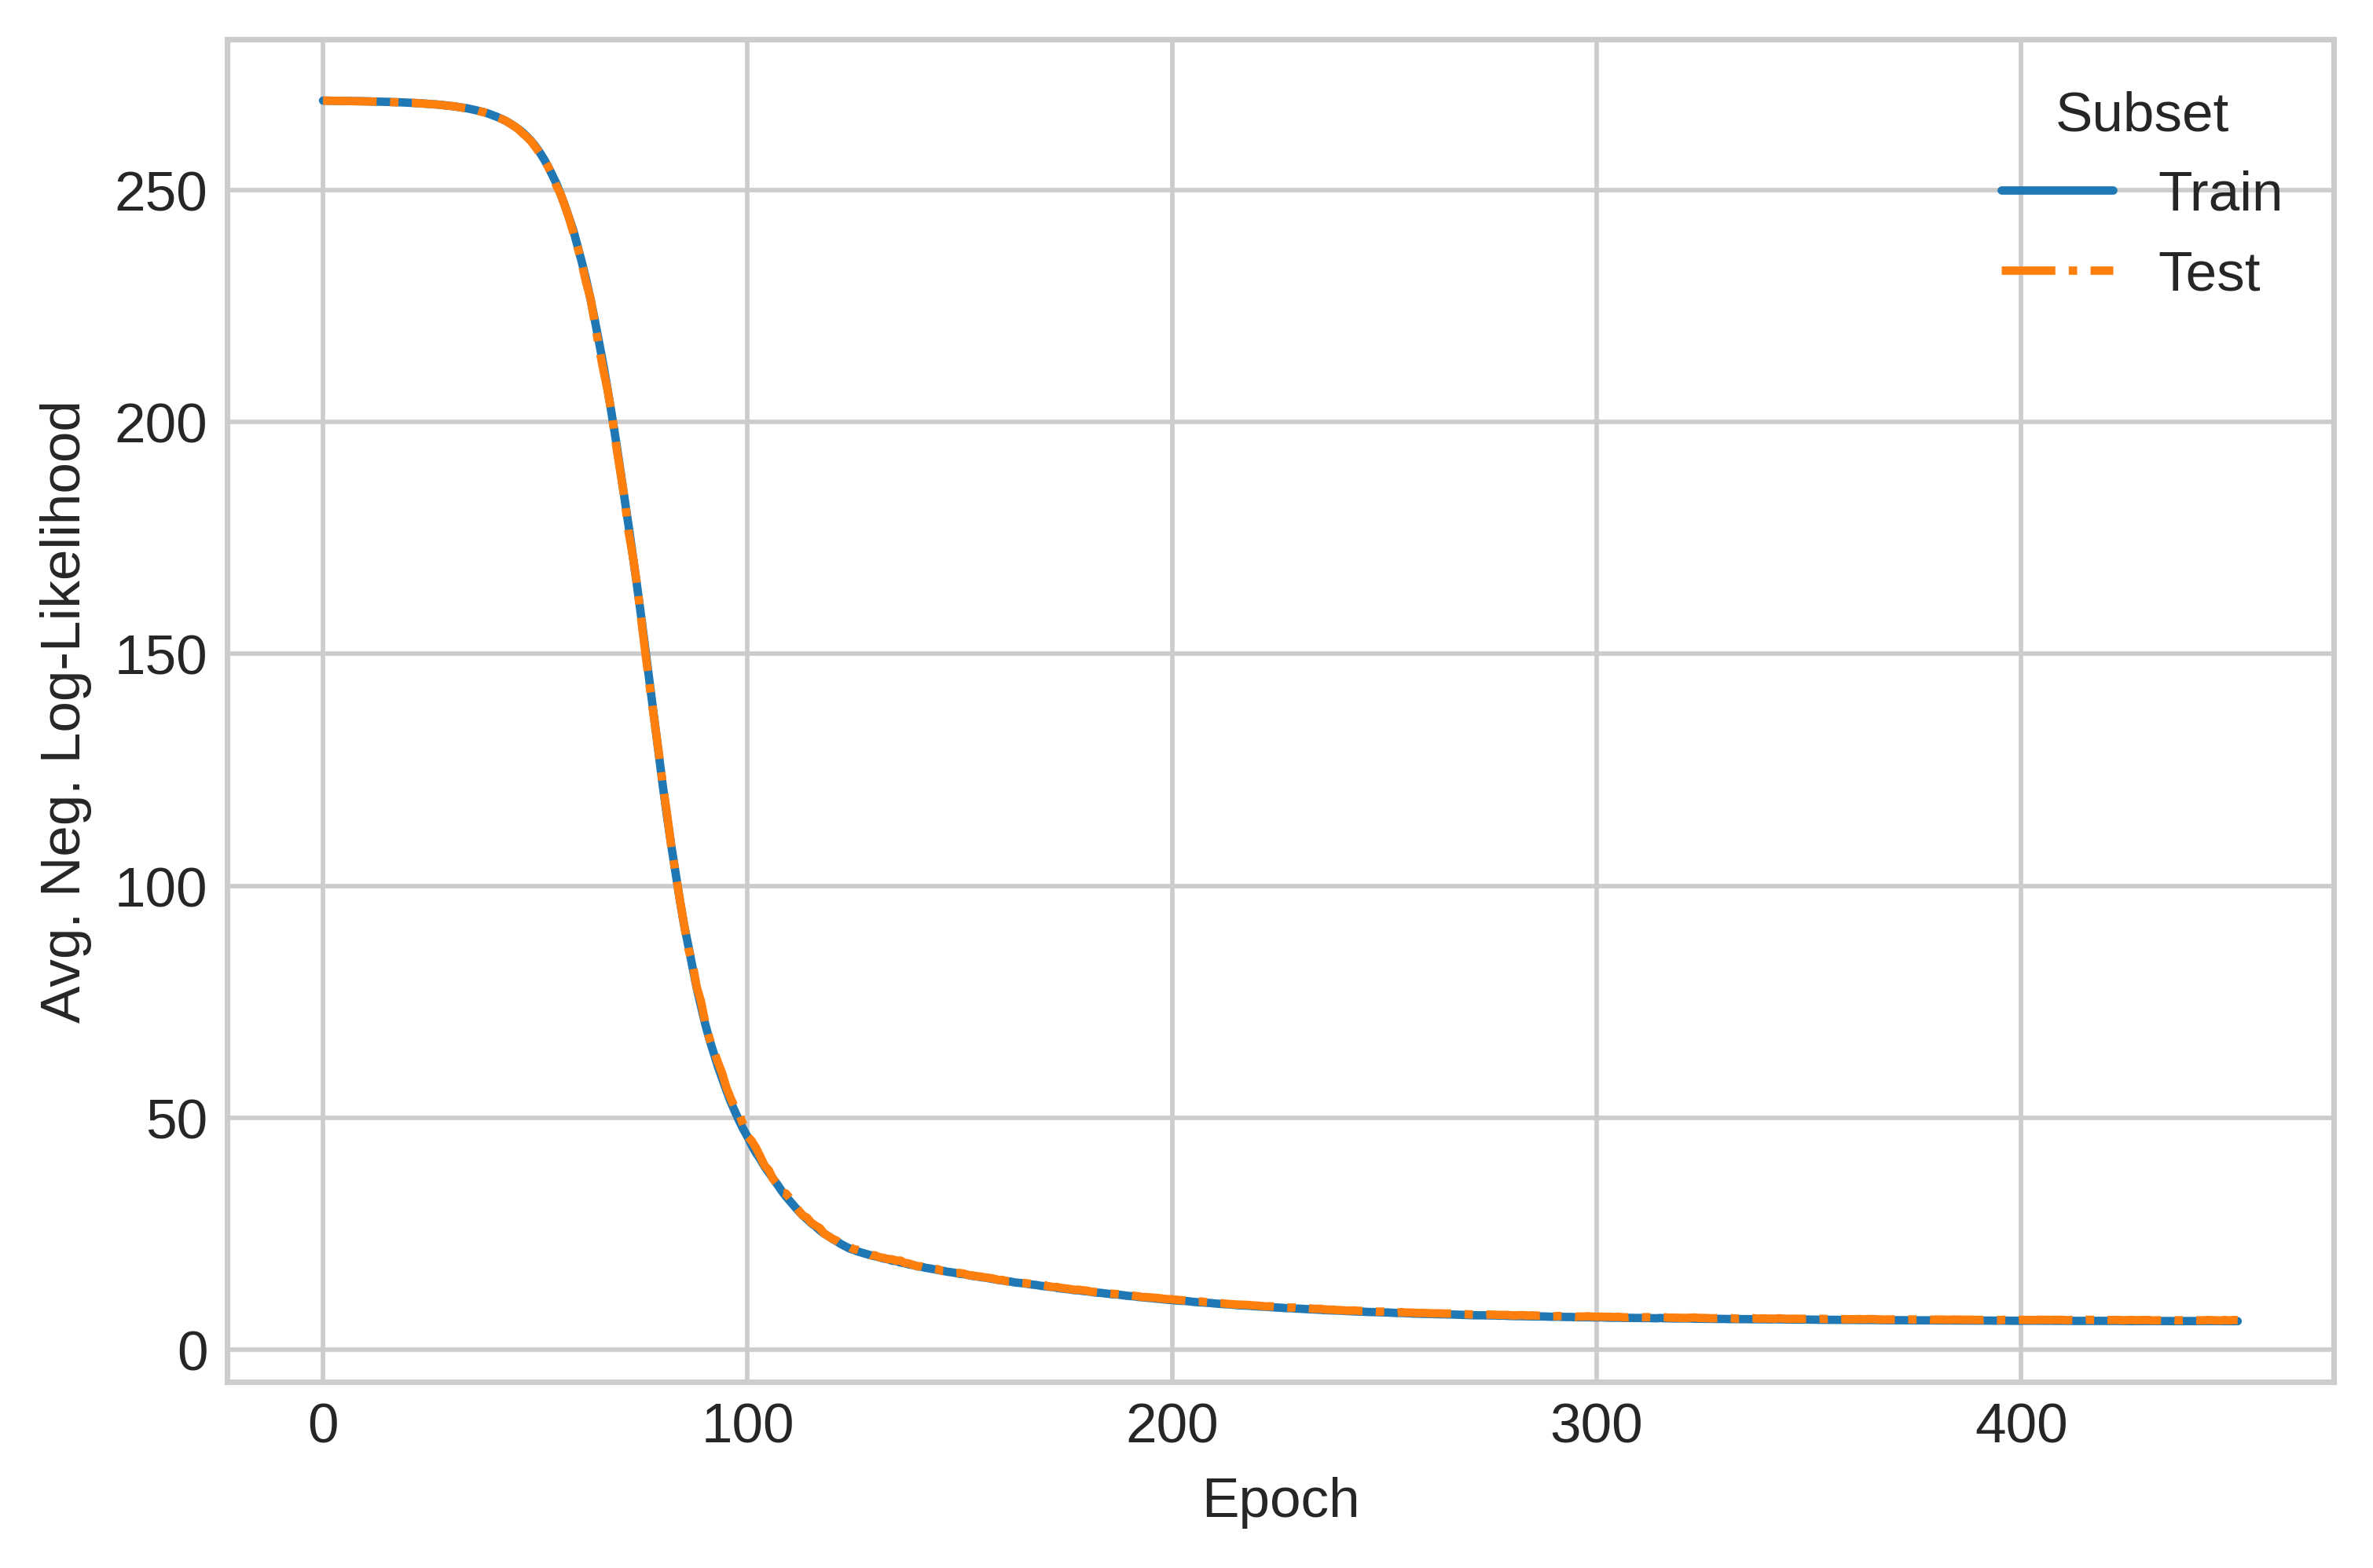

In [4]:
plt.figure(figsize=(6, 4), dpi=512)

df.train.plot.line(label="Train")
df.test.plot.line(label="Test", linestyle="-.")

plt.legend(title="Subset")
plt.xlabel("Epoch")
plt.ylabel("Avg. Neg. Log-Likelihood")
plt.tight_layout()
plt.savefig("outputs/made/train-curve.pdf")

In [5]:
made = torch.load("outputs/made/made-model.pt", map_location="cpu")
values = torch.arange(29)
with torch.inference_mode():
    prior = made[-1].bias.detach().softmax(-1).cpu()
    expected_values = (values * prior).sum(-1)

In [6]:
device = "cuda"
num_sample = 1000
one_hot_input = False
max_value = 28

dataloader_train = torch.utils.data.DataLoader(
    utils.dataset.ObjectCooccurrenceCOCODataset(
        "dataset/coco2017-cooccurences-train.csv"
    ),
    batch_size=16384,
    num_workers=8,
    pin_memory=device == "cuda",
    pin_memory_device=device,
)

dataloader_valid = torch.utils.data.DataLoader(
    utils.dataset.ObjectCooccurrenceCOCODataset(
        "dataset/coco2017-cooccurences-valid.csv"
    ),
    batch_size=16384,
    num_workers=8,
    pin_memory=device == "cuda",
    pin_memory_device=device,
)


log_likelihood_train = log_likelihood(
    dataloader_train, made, num_sample, one_hot_input, device, max_value
)

log_posterior_train = log_posterior(
    dataloader_train, made, num_sample, one_hot_input, device, max_value
)

log_likelihood_valid = log_likelihood(
    dataloader_valid, made, num_sample, one_hot_input, device, max_value
)

log_posterior_valid = log_posterior(
    dataloader_valid, made, num_sample, one_hot_input, device, max_value
)

In [7]:
df_train = pd.read_csv("dataset/coco2017-cooccurences-train.csv")
df_valid = pd.read_csv("dataset/coco2017-cooccurences-valid.csv")

avg_neg_log_posterior_train = -log_posterior_train / len(df_train)
avg_neg_log_posterior_valid = -log_posterior_valid / len(df_valid)
avg_neg_log_likelihood_train = -log_likelihood_train / len(df_train)
avg_neg_log_likelihood_valid = -log_likelihood_valid / len(df_valid)

total_neg_log_likelihood = avg_neg_log_likelihood_train * len(df_train)

total_params = sum(p.numel() for p in made.parameters())
bic = -total_neg_log_likelihood - total_params / 2 * log(len(df_train))

In [8]:
with open("outputs/overall/made.json", "w", encoding="utf-8") as file:
    json.dump(
        dict(
            model="MADE",
            kind="Advanced Model",
            total_parameters=total_params,
            avg_train_nll=avg_neg_log_likelihood_train,
            avg_test_nll=avg_neg_log_likelihood_valid,
            avg_train_nlp=avg_neg_log_posterior_train,
            avg_test_nlp=avg_neg_log_posterior_valid,
            neg_bic=-bic,
        ),
        file,
        ensure_ascii=False,
        indent=4,
    )

In [9]:
sample = torch.from_numpy(df_data.iloc[0].to_numpy()).float()
nonzeros = torch.where(sample > 0)[0]

NameError: name 'df_data' is not defined

In [ ]:
df_data = pd.read_csv("dataset/coco2017-cooccurences-train.csv").iloc[:, 8:]
df_data.columns = [
    col.split("-")[0].upper().replace("]", "").replace("[", "")
    for col in df_data.columns
]

In [ ]:
df_prior_mixture = pd.read_csv("outputs/mixture/expected-value-01.csv")

In [ ]:
exp = np.stack([expected_values.numpy(), df_prior_mixture.iloc[0].values])
exp = pd.DataFrame(exp, columns=df_data.columns)

exp.insert(0, "MODEL", ["MADE", "Independent"])
exp

In [ ]:
ex = pd.melt(exp)
ex.insert(0, "Model", ["MADE", "Independent"] * 81)
ex = ex.iloc[2:]
ex

In [ ]:
plt.figure(figsize=(16, 8), dpi=512)

ex_made = ex[ex["Model"] == "MADE"]
ex_idp = ex[ex["Model"] == "Independent"]

plt.plot(ex_made.variable, ex_made.value, "o-", label="MADE")
plt.plot(ex_idp.variable, ex_idp.value, "o-", label="Independent")

plt.xlabel(None)
plt.ylabel("Prior Expected Value")

plt.xticks(df_data.columns, rotation="vertical")
plt.legend()

plt.tight_layout()

plt.savefig("outputs/made/expected-prior.pdf")